# Project 2

<bk>
    Dieter Brehm and Corinne Wilklow

In [13]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import matplotlib.pyplot

In [14]:
m = UNITS.meter
ft =  UNITS.foot
inch = UNITS.inch


W = UNITS.watt

J = UNITS.joule
btu = UNITS.btu

degC = UNITS.celsius
K = UNITS.kelvin
degF = UNITS.fahrenheit 

hr = UNITS.hour

<Unit('hour')>

In [15]:
data = pd.read_csv('DataOWall.csv', parse_dates=[0], index_col=0, header=0, skiprows=[1,2])
data.head()

,Q_in,Q_out,T_int,T_ext
2014-10-05 16:30:00,10.994,6.840,16.92,14.68
2014-10-05 16:35:00,10.952,6.012,16.92,14.69
2014-10-05 16:40:00,10.882,7.040,16.93,14.66
2014-10-05 16:45:00,10.798,8.880,16.93,14.59
2014-10-05 16:50:00,10.756,10.491,16.94,14.50


Convert Index entries to seconds, noticing the spacing between recordings

In [4]:
timestamp_0 = get_first_label(data)
time_deltas = data.index - timestamp_0;

In [16]:
data.index = time_deltas.days * 86400 + time_deltas.seconds
print(data.head())

# make a function that can interpolate T_ext values
ext_func = interpolate(data.T_ext)

        Q_in   Q_out  T_int  T_ext
0     10.994   6.840  16.92  14.68
300   10.952   6.012  16.92  14.69
600   10.882   7.040  16.93  14.66
900   10.798   8.880  16.93  14.59
1200  10.756  10.491  16.94  14.50


Add units to each dataframe (Q_in, Q_out, T_int, T_ext)

In [17]:
data.Q_in.units = W / m**2
data.Q_out.units = W / m**2
data.T_int.units = degC
data.T_ext.units = degC;

In [25]:
def make_system(init, R, d, SA, m, c):
    """Make a system object for the HIV model.
    
    start_temp: starting temp of room 
    gamma: recovery rate in days
    
    returns: System object
    """
    

    t0 = 0
    t_end = 100
    dt = 0.1

    return System(init=init, t0=t0, t_end=t_end, dt=dt, R=R, d=d, SA=SA, m=m, c=c)

In [28]:
init = State(T_int=65, T_ext=get_first_value(data.T_ext)*9/5+32)
#
R = 4 #ft^2*deg5/btu/hr/in
d = 3 #inches

#room dimensions
l = 6 #ft
w = 6 #ft
h = 6 #ft

#SA = (l * w * 4 + h * l * 2) * 10.7639 #ft^2 <--- wrong eq
SA = 2 * w + 2 * w * h + 2 * h
print("surface area calculation", SA)
V = l * w * h #m^3

rho = 1 #density of air
g = 9.8 #m/s^2, acceleration due to gravity
m = (rho * V * g) * 2.2 #mass of air in room in lb

c = 0.171 #btu/lbm*R

print("first exterior value", get_first_value(data.T_ext)*9/5+32)

system = make_system(init, R, d, SA, m, c)

surface area calculation 96
first exterior value 58.424


,values
init,T_int 65.000 T_ext 58.424 dtype: float64
t0,0
t_end,100
dt,0.1
R,4
d,3
SA,96
m,4656.96
c,0.171


In [29]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end, system.dt):
        frame.row[t+system.dt] = update_func(frame.row[t], t, system)
        print("time", t)
    
    return frame

In [30]:
def update_func(state, t, system):
    """Update the model.
    
    state: State with variables T_int, T_ext
    dt: time step
    system: System
    
    returns: State object
    """
    
    T_int, T_ext = state
    
    #delta_T = T_int - T_ext
    delta_T = T_int - ext_func(t) # t should be in seconds
    
    dQ= (system.SA * delta_T / (system.R * system.d))* system.dt
    
    dT = dQ / (system.c * system.m) 
    
    T_int = T_int - dT
    
    return State(T_int = T_int, T_ext = T_ext)

In [31]:
update_func(system.init, system.t0, system)

,values
T_int,64.949449
T_ext,58.424000


In [32]:
results = run_simulation(system,update_func)

time 0.0
time 0.1
time 0.2
time 0.30000000000000004
time 0.4
time 0.5
time 0.6
time 0.7
time 0.7999999999999999
time 0.8999999999999999
time 0.9999999999999999
time 1.0999999999999999
time 1.2
time 1.3
time 1.4000000000000001
time 1.5000000000000002
time 1.6000000000000003
time 1.7000000000000004
time 1.8000000000000005
time 1.9000000000000006
time 2.0000000000000004
time 2.1000000000000005
time 2.2000000000000006
time 2.3000000000000007
time 2.400000000000001
time 2.500000000000001
time 2.600000000000001
time 2.700000000000001
time 2.800000000000001
time 2.9000000000000012
time 3.0000000000000013
time 3.1000000000000014
time 3.2000000000000015
time 3.3000000000000016
time 3.4000000000000017
time 3.5000000000000018
time 3.600000000000002
time 3.700000000000002
time 3.800000000000002
time 3.900000000000002
time 4.000000000000002
time 4.100000000000001
time 4.200000000000001
time 4.300000000000001
time 4.4
time 4.5
time 4.6
time 4.699999999999999
time 4.799999999999999
time 4.89999999999

time 37.30000000000026
time 37.40000000000026
time 37.50000000000026
time 37.600000000000264
time 37.700000000000266
time 37.80000000000027
time 37.90000000000027
time 38.00000000000027
time 38.10000000000027
time 38.20000000000027
time 38.300000000000274
time 38.400000000000276
time 38.50000000000028
time 38.60000000000028
time 38.70000000000028
time 38.80000000000028
time 38.90000000000028
time 39.000000000000284
time 39.100000000000286
time 39.20000000000029
time 39.30000000000029
time 39.40000000000029
time 39.50000000000029
time 39.60000000000029
time 39.700000000000294
time 39.800000000000296
time 39.9000000000003
time 40.0000000000003
time 40.1000000000003
time 40.2000000000003
time 40.3000000000003
time 40.400000000000304
time 40.500000000000306
time 40.60000000000031
time 40.70000000000031
time 40.80000000000031
time 40.90000000000031
time 41.00000000000031
time 41.100000000000314
time 41.200000000000315
time 41.30000000000032
time 41.40000000000032
time 41.50000000000032
time

time 80.79999999999968
time 80.89999999999968
time 80.99999999999967
time 81.09999999999967
time 81.19999999999966
time 81.29999999999966
time 81.39999999999965
time 81.49999999999964
time 81.59999999999964
time 81.69999999999963
time 81.79999999999963
time 81.89999999999962
time 81.99999999999962
time 82.09999999999961
time 82.1999999999996
time 82.2999999999996
time 82.3999999999996
time 82.49999999999959
time 82.59999999999958
time 82.69999999999958
time 82.79999999999957
time 82.89999999999957
time 82.99999999999956
time 83.09999999999955
time 83.19999999999955
time 83.29999999999954
time 83.39999999999954
time 83.49999999999953
time 83.59999999999953
time 83.69999999999952
time 83.79999999999951
time 83.89999999999951
time 83.9999999999995
time 84.0999999999995
time 84.19999999999949
time 84.29999999999949
time 84.39999999999948
time 84.49999999999947
time 84.59999999999947
time 84.69999999999946
time 84.79999999999946
time 84.89999999999945
time 84.99999999999945
time 85.09999999

,T_int,T_ext
0.0,65.000000,58.424
0.1,64.949449,58.424
0.2,64.898948,58.424
0.3,64.848499,58.424
0.4,64.798099,58.424
0.5,64.747751,58.424
0.6,64.697453,58.424
0.7,64.647206,58.424
0.8,64.597009,58.424
0.9,64.546863,58.424


(0, 200)

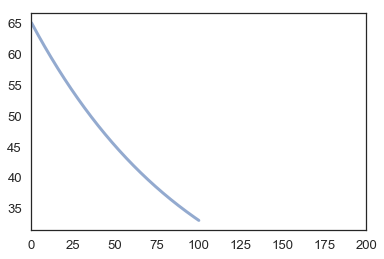

In [34]:
plot(results.T_int)
axes = plt.gca()
axes.set_xlim([0,200])